In [1]:
library(tidyverse)
library(jsonlite)
library(tidystringdist)
library(kableExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten



Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows




In [2]:
BASE_DIR <- '/Users/jon/Documents/NEU/Projects/llm-mutation-testing/mutation-testing-data'

# find all mutants.json files in BASE_DIR
mutants_files <- list.files(path = BASE_DIR, recursive = TRUE, pattern = "mutants.json", full.names = TRUE)

# load in all mutants.json files, adding a column for the file path
mutants <- map_df(mutants_files, ~fromJSON(.x) %>%
                    mutate(file = .x)) %>%
        extract(file, c('model','template','temperature','run','project'), "mutation-testing-data/([^/]+)/template-([^-]+)-([^/]+)/run([^/]+)/projects/([^/]+)/")  %>%
        filter(!is.na(project))

mutants <- tidy_stringdist(mutants, "originalCode", "replacement", method = "lv")

In [3]:
# calculate string edit distance between originalCode and replacement
# mutants %>%
# mutate(b=replacement,a=originalCode)%>%
# head() %>%
  # mutate(edit_distance = tidy_stringdist(a, b, method = "jaccard"))
# mutants%>% head()
mutantEditDistance <- mutants %>% group_by(project,model,template,temperature) %>% summarise(mean_edit_distance = mean(lv)) %>% ungroup() %>% 
mutate(mean_edit_distance = round(mean_edit_distance,2)) 

mutantEditDistance %>%
filter(template=="full" & temperature=="0.0")%>%
pivot_wider(names_from=c("model","template","temperature"), values_from=mean_edit_distance) %>%
select(project, `codellama-34b-instruct_full_0.0`, `codellama-13b-instruct_full_0.0`, `llama-3.3-70b-instruct_full_0.0`, `gpt-4o-mini_full_0.0`,  `mixtral-8x7b-instruct_full_0.0`) %>%
kable(format.args = list(big.mark = ","), escape = F,
 format = "latex",booktabs = TRUE, linesep = "")


 mutantEditDistance %>%
filter(model=='codellama-34b-instruct')%>%
pivot_wider(names_from=c("model","template","temperature"), values_from=mean_edit_distance) %>%
select(project, `codellama-34b-instruct_full_0.0`,`codellama-34b-instruct_onemutation_0.0`,
`codellama-34b-instruct_noexplanation_0.0`,
`codellama-34b-instruct_noinstructions_0.0`,
`codellama-34b-instruct_full_genericsystemprompt-0.0`,
`codellama-34b-instruct_basic_0.0`
 ) %>%
kable(format.args = list(big.mark = ","), escape = F,
 format = "latex",booktabs = TRUE, linesep = "")

`summarise()` has grouped output by 'project', 'model', 'template'. You can
override using the `.groups` argument.



\begin{tabular}{lrrrrr}
\toprule
project & codellama-34b-instruct_full_0.0 & codellama-13b-instruct_full_0.0 & llama-3.3-70b-instruct_full_0.0 & gpt-4o-mini_full_0.0 & mixtral-8x7b-instruct_full_0.0\\
\midrule
Complex.js & 4.27 & 4.63 & 6.90 & 6.35 & 8.95\\
countries-and-timezones & 11.13 & 9.78 & 11.71 & 11.33 & 13.65\\
crawler-url-parser & 9.50 & 8.82 & 10.71 & 10.05 & 12.65\\
delta & 9.55 & 8.88 & 13.01 & 11.44 & 14.15\\
image-downloader & 12.67 & 10.74 & 12.66 & 13.88 & 14.21\\
node-dirty & 7.53 & 7.42 & 12.08 & 10.20 & 12.08\\
node-geo-point & 8.86 & 8.15 & 8.97 & 9.53 & 15.27\\
node-jsonfile & 9.73 & 10.07 & 11.10 & 11.00 & 10.81\\
plural & 8.14 & 6.29 & 9.27 & 8.31 & 10.37\\
pull-stream & 6.72 & 8.71 & 7.82 & 8.06 & 9.67\\
q & 8.61 & 9.71 & 11.17 & 9.92 & 13.23\\
spacl-core & 9.30 & 10.84 & 8.95 & 8.70 & 12.61\\
zip-a-folder & 9.85 & 12.38 & 11.87 & 11.23 & 11.61\\
\bottomrule
\end{tabular}


\begin{tabular}{lrrrrrr}
\toprule
project & codellama-34b-instruct_full_0.0 & codellama-34b-instruct_onemutation_0.0 & codellama-34b-instruct_noexplanation_0.0 & codellama-34b-instruct_noinstructions_0.0 & codellama-34b-instruct_full_genericsystemprompt-0.0 & codellama-34b-instruct_basic_0.0\\
\midrule
Complex.js & 4.27 & 3.37 & 5.09 & 4.27 & 4.17 & 11.98\\
countries-and-timezones & 11.13 & 7.75 & 11.17 & 10.87 & 10.85 & 11.29\\
crawler-url-parser & 9.50 & 6.41 & 9.46 & 9.49 & 9.30 & 20.04\\
delta & 9.55 & 7.38 & 9.91 & 9.43 & 9.14 & 19.63\\
image-downloader & 12.67 & 8.82 & 12.89 & 11.01 & 11.48 & 21.92\\
node-dirty & 7.53 & 6.90 & 7.58 & 7.41 & 7.51 & 17.52\\
node-geo-point & 8.86 & 6.10 & 8.79 & 7.75 & 8.66 & 15.66\\
node-jsonfile & 9.73 & 6.98 & 9.76 & 7.77 & 8.91 & 11.64\\
plural & 8.14 & 5.21 & 8.41 & 7.58 & 7.80 & 23.64\\
pull-stream & 6.72 & 4.57 & 7.53 & 7.48 & 7.30 & 11.92\\
q & 8.61 & 7.61 & 9.21 & 8.60 & 8.58 & 16.18\\
spacl-core & 9.30 & 5.86 & 10.44 & 9.43 & 9.44 & 14.27

In [4]:
# mutants %>% filter(project=='image-downloader' & (template=='full' | template=='basic') & temperature=='0.0') 
# pivot_wider()

biggestDifferences <- mutants %>% group_by(project, template, temperature, model) %>%
slice_max(lv,n = 2, with_ties= FALSE) %>% arrange(project, model, template, temperature)
leastDifferences <- mutants %>% group_by(project, template, temperature, model) %>%
slice_min(lv,n = 2, with_ties= FALSE) %>% arrange(project, model, template, temperature)

write.csv(biggestDifferences, file = "biggestDifferences.csv", row.names = FALSE)
write.csv(leastDifferences, file = "leastDifferences.csv", row.names = FALSE)


In [5]:
mutants_baseline <- mutants %>% filter(template=='full' & temperature=='0.0' & model=='codellama-34b-instruct')

In [6]:
mutants %>% filter(!(template=='full' & temperature=='0.0' & model=='codellama-34b-instruct')) %>%
inner_join(mutants_baseline, by=c('project','startLine','endLine','startColumn','endColumn','originalCode'), suffix = c("",".baseline"), relationship = "many-to-many")  %>% 
mutate(lvDiff=abs(lv - lv.baseline)) %>%
group_by(project,model,template,temperature) %>% summarise(mean_lvDiff = mean(lvDiff)) %>% ungroup() %>%
pivot_wider(names_from = c("model","template","temperature"), values_from = mean_lvDiff) 
# select(project,template,temperature,run,model,originalCode,replacement.baseline,replacement,lvDiff)%>%
# head()

`summarise()` has grouped output by 'project', 'model', 'template'. You can
override using the `.groups` argument.


project,codellama-13b-instruct_full_0.0,codellama-34b-instruct_basic_0.0,codellama-34b-instruct_full_0.25,codellama-34b-instruct_full_0.5,codellama-34b-instruct_full_1.0,codellama-34b-instruct_full_genericsystemprompt-0.0,codellama-34b-instruct_noexplanation_0.0,codellama-34b-instruct_noinstructions_0.0,codellama-34b-instruct_onemutation_0.0,gpt-4o-mini_full_0.0,llama-3.3-70b-instruct_full_0.0,mixtral-8x7b-instruct_full_0.0
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Complex.js,3.029531,8.892899,1.978023,2.448525,4.379572,1.636050,2.346533,1.968825,1.858666,4.778237,5.050464,6.205143
countries-and-timezones,7.731699,6.927419,5.964977,6.580906,8.674877,5.661265,6.633782,6.751040,6.127778,8.447989,8.692504,9.216538
crawler-url-parser,6.407374,17.646591,4.714363,6.072846,8.710418,4.246158,4.992904,4.371172,3.949206,7.595414,8.720511,10.252970
delta,6.173866,12.739788,4.024385,5.215778,7.883530,3.554530,4.605344,4.742474,3.989054,8.526899,9.576584,9.268240
image-downloader,6.559651,17.385714,5.674227,6.432223,8.670696,5.374587,5.788618,5.784014,4.718535,8.667029,9.373552,9.222222
node-dirty,4.308391,9.668621,3.963428,4.584016,6.511032,3.290323,3.682717,4.050228,3.326154,6.262564,8.359389,7.980945
node-geo-point,6.461708,14.053691,3.127130,4.589208,7.294772,2.596789,3.227074,3.991463,3.732180,7.195719,7.416413,11.665262
node-jsonfile,5.977654,8.066667,4.964872,5.884913,8.132706,5.026067,4.859899,5.493874,4.400524,7.235451,7.274338,7.524360
plural,7.116323,20.358684,5.156992,6.015751,8.590891,4.239615,5.627558,5.120312,4.388862,8.086278,9.406288,9.392463


`summarise()` has grouped output by 'model', 'template', 'temperature',
'project', 'run', 'startLine', 'startColumn', 'endLine', 'endColumn',
'originalCode'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'model', 'template', 'temperature',
'project', 'startLine', 'startColumn', 'originalCode'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'model', 'template', 'temperature'. You can
override using the `.groups` argument.
Adding missing grouping variables: `model`, `template`, `temperature`


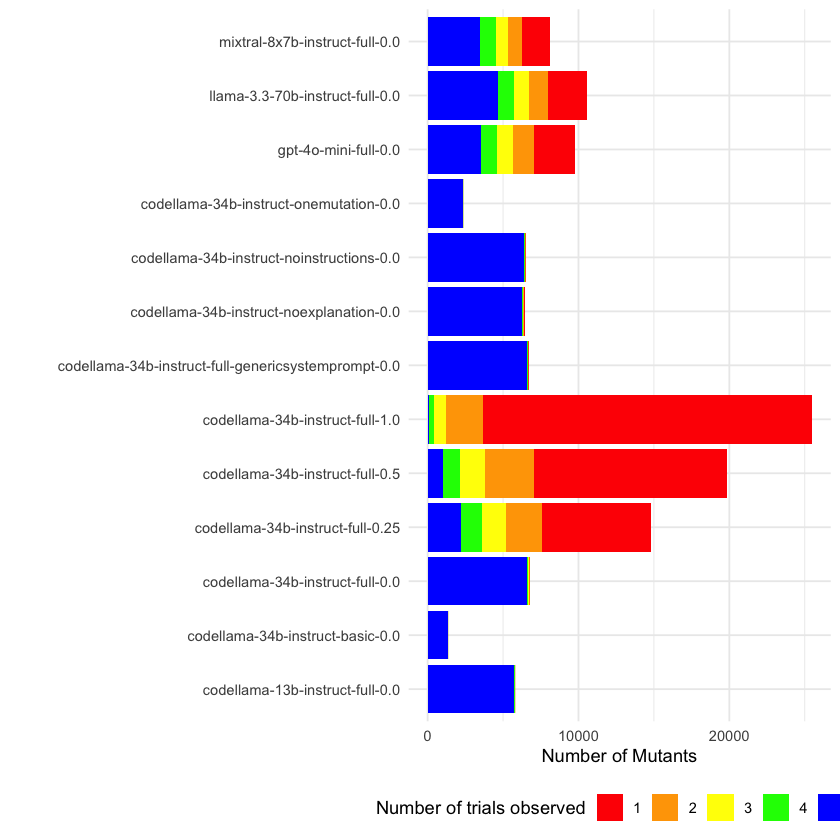

In [42]:
# for each model/template/temperature, calculate how often the same mutation was made
# prepare to find which mutants are repeated across runs by ensuring that each mutant appears exactly once
uniqueMutantsByRun <- mutants %>% group_by(model, template, temperature, project, run, startLine, startColumn, endLine, endColumn, originalCode, replacement) %>%
    summarise(repeatPerRun=n()) %>% ungroup()

mutantStability <-  uniqueMutantsByRun %>% group_by(model, template, temperature, project, startLine, startColumn, originalCode, replacement) %>% summarise(nOccurrence=n()) %>% ungroup() %>%
group_by(model, template, temperature, nOccurrence) %>% summarise(n=n())  %>% mutate(label = paste(model, template, temperature, sep="-")) 

# stacked bar chart of mutation stability
mutantStability %>% select(label,nOccurrence, n) %>%
mutate(nOccurrence=as.factor(nOccurrence))%>%
ggplot(aes(fill=nOccurrence, y=label, x=n)) +
# make the fill be a discrete scale from red (1) to green (5)
scale_fill_manual(values = c("red", "orange", "yellow", "green", "blue")) +
geom_bar(stat="identity") +
    theme_minimal() + theme(legend.position = "bottom") + 
        theme_minimal() + theme(legend.position = "bottom") + 
    xlab("Number of Mutants") +
    ylab("") +
    # set legend title
    labs(fill = "Number of trials observed") +
    theme(legend.position = "bottom") 
    # output PDF
    ggsave("mutantStability-all.pdf", width = 9, height = 3, units = "in")

`summarise()` has grouped output by 'model', 'template', 'temperature',
'project', 'run', 'startLine', 'startColumn', 'endLine', 'endColumn',
'originalCode'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'model', 'template', 'temperature',
'project', 'startLine', 'startColumn', 'originalCode'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'model', 'template', 'temperature'. You can
override using the `.groups` argument.
Adding missing grouping variables: `model`, `template`, `temperature`


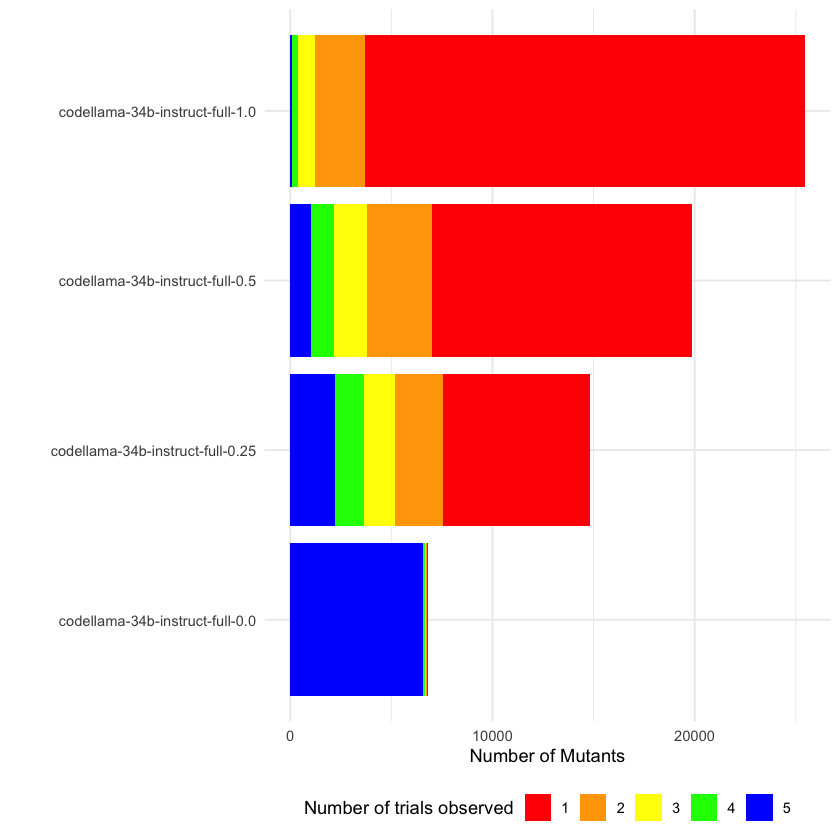

In [48]:
# for each model/template/temperature, calculate how often the same mutation was made
# prepare to find which mutants are repeated across runs by ensuring that each mutant appears exactly once
uniqueMutantsByRun <- mutants %>% 
filter(model=='codellama-34b-instruct' & template=='full' & temperature != 'genericsystemprompt-0.0')%>%
group_by(model, template, temperature, project, run, startLine, startColumn, endLine, endColumn, originalCode, replacement) %>%
    summarise(repeatPerRun=n()) %>% ungroup()

mutantStability <-  uniqueMutantsByRun %>% group_by(model, template, temperature, project, startLine, startColumn, originalCode, replacement) %>% summarise(nOccurrence=n()) %>% ungroup() %>%
group_by(model, template, temperature, nOccurrence) %>% summarise(n=n())  %>% mutate(label = paste(model, template, temperature, sep="-")) 

# stacked bar chart of mutation stability
mutantStability %>% select(label,nOccurrence, n) %>%
mutate(nOccurrence=as.factor(nOccurrence))%>%
ggplot(aes(fill=nOccurrence, y=label, x=n)) +
# make the fill be a discrete scale from red (1) to green (5)
scale_fill_manual(values = c("red", "orange", "yellow", "green", "blue")) +
geom_bar(stat="identity") +
    theme_minimal() + theme(legend.position = "bottom") + 
    xlab("Number of Mutants") +
    ylab("") +
    # set legend title
    labs(fill = "Number of trials observed") +
    theme(legend.position = "bottom")
    # output PDF
    ggsave("mutantStability-codellama-34b-instruct-full.pdf", width = 9, height = 2, units = "in")

Adding missing grouping variables: `model`, `template`, `temperature`


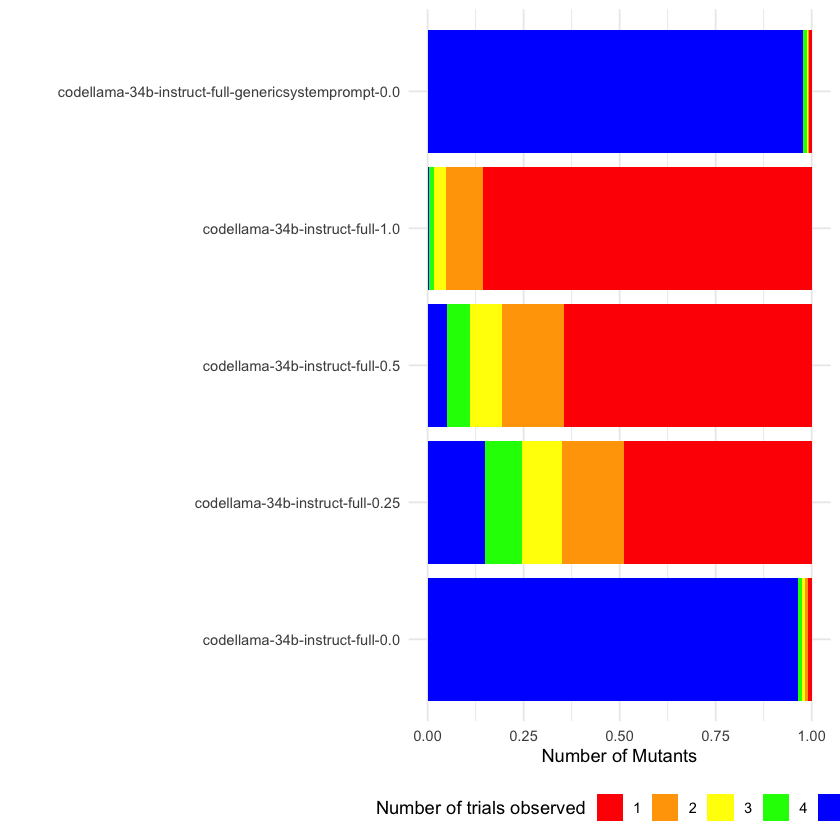

In [ ]:
mutantStability %>% select(label,nOccurrence, n) %>%
# change n to be a percentage of the total n for that label
group_by(label) %>% mutate(n=n/sum(n)) %>% ungroup() %>%
mutate(nOccurrence=as.factor(nOccurrence))%>%
ggplot(aes(fill=nOccurrence, x=n, y=label)) +
# make the fill be a discrete scale from red (1) to green (5)
scale_fill_manual(values = c("red", "orange", "yellow", "green", "blue")) +
geom_bar(stat="identity") +
    theme_minimal() + theme(legend.position = "bottom") + 
    xlab("Number of Mutants") +
    ylab("") +
    # set legend title
    labs(fill = "Number of trials observed") +
    theme(legend.position = "bottom") 

`summarise()` has grouped output by 'model', 'template', 'temperature',
'project', 'run', 'startLine', 'startColumn', 'endLine', 'endColumn',
'originalCode'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'model', 'template', 'temperature',
'project', 'startLine', 'startColumn', 'originalCode'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'model', 'template', 'temperature',
'project', 'startLine', 'startColumn'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'model', 'template'. You can override using
the `.groups` argument.
Adding missing grouping variables: `model`, `template`


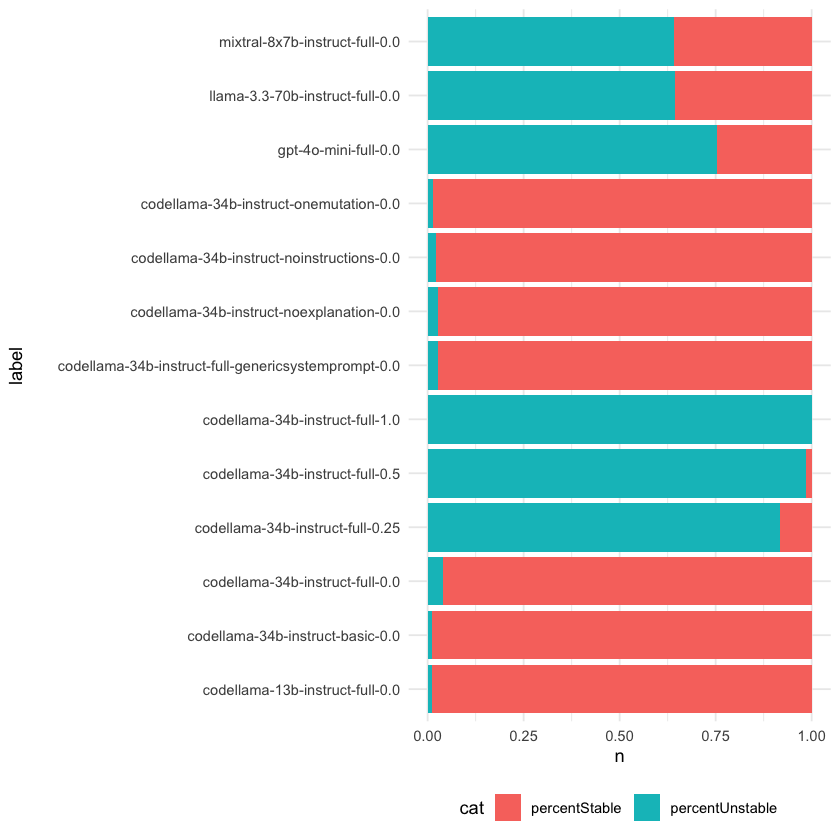

In [9]:
# for each mutant location, report simply whether the exact same 3 mutants were made across all runs (or not)

# for each model/template/temperature, calculate how often the same mutation was made
# prepare to find which mutants are repeated across runs by ensuring that each mutant appears exactly once
uniqueMutantsByRun <- mutants %>% group_by(model, template, temperature, project, run, startLine, startColumn, endLine, endColumn, originalCode, replacement) %>%
    summarise(repeatPerRun=n()) %>% ungroup()

mutantStabilityByLocation <-  mutants %>% group_by(model, template, temperature, project, startLine, startColumn, originalCode, replacement) %>%
    summarise(nOccurrence=n()) %>% ungroup() %>%
    mutate(occurredAllRuns = (nOccurrence==5)) %>%
    group_by(model, template, temperature, project, startLine, startColumn, originalCode) %>%
    summarise(total=n(), occurredAllRuns=sum(occurredAllRuns), didNotOccurAllRuns=total-occurredAllRuns) %>%
    ungroup()%>%
    group_by(model, template, temperature) %>%
    summarise(locations=n(),fullyStableLocations=sum(occurredAllRuns == total), unstableLocations=sum(occurredAllRuns != total))  %>%
        mutate(label=paste(model, template, temperature, sep="-"),
        percentStable=fullyStableLocations/locations,
        percentUnstable=unstableLocations/locations)        

# # stacked bar chart of mutation stability, by percentage
mutantStabilityByLocation %>% 
pivot_longer(names_to = "cat", values_to = "n", cols = c("percentStable", "percentUnstable")) %>%
select(label,cat, n) %>%
ggplot(aes(fill=cat, x=n, y=label)) +
# scale_fill_manual(values = c("green", "red")) +
geom_bar(stat="identity") +
    theme_minimal() + theme(legend.position = "bottom")

In [ ]:
# For each of the 5 experiments, look to see how often each mutant occurs